# Transaction Data Generator 
Similate transaction data for Python tutorials 

In [1]:
#imports
import numpy as np
import pandas as pd
import random
import string

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import csv
import datetime
from datetime import timedelta,datetime, date

# Generate transaction

In [2]:
#Customer type details
cust_types = {'Young Professional': { 'min_income':20000, 'max_income':100000, 'proportion':0.18},
              'Experienced Professional': { 'min_income':50000, 'max_income':200000, 'proportion':0.28},
              'Parent': { 'min_income':50000, 'max_income':200000, 'proportion':0.15},
              'College Student': { 'min_income':5000, 'max_income':25000, 'proportion':0.09},
              'School Student': { 'min_income':2000, 'max_income':8000, 'proportion':0.05},
              'Retired': { 'min_income':10000, 'max_income':50000, 'proportion':0.2},
              'Unemployed': { 'min_income':1000, 'max_income':5000, 'proportion':0.05}}

#Expenditure types
exp_types = ['GROCERIES','CLOTHING','HOUSING','EDUCATION','HEALTH',
             'TRAVEL','ENTERTAINMENT','GAMBLING',
             'UTILITIES','TAX','FINES']

#Proporition of income going to each expenditure group
exp_prop = {'Young Professional':[0.04,0.12,0.16,0.08,0.04,0.08,0.24,0.1,0.04,0.04,0.04],
        'Experienced Professional':[0.08,0.08,0.15,0.04,0.08,0.08,0.15,0.06,0.08,0.08,0.04],
        'Parent':[0.15,0.04,0.23,0.15,0.08,0.04,0.04,0.01,0.08,0.04,0.04],
        'College Student':[0.09,0.04,0.09,0.35,0.04,0.09,0.13,0.04,0.04,0,0.04],
        'School Student':[0.05,0.02,0,0.05,0,0.19,0.65,0,0,0,0],
        'Retired':[0.09,0.04,0.22,0,0.18,0.07,0.15,0.01,0.07,0.01,0.01],
        'Unemployed':[0.1,0,0.2,0,0.05,0.4,0,0.1,0.1,0,0.05]}

#Behaviour of each expenditure group
exp_behave = {'Exclude':[0,0,0.5,0.5,0,0.2,0,0.6,0,0,0.9],
'Exclude Monthly':[0,0.5,0,0,0.5,0.2,0,0.1,0,0.05,0.9],
'Annual Inflation':[0.08,0.08,0.05,0.02,0.05,0.2,0.02,0.05,0.02,0.005,0],
'Holiday Increase':[1,1,0,0,0,1,1,1,0,0,0],
'Regular Min':[0,0,1,1,0,0,0,0,1,1,0],
'Regular Max':[1,0,1,1,1,1,1,0,1,1,0],
'Regular %':[0.1,0,1,0.9,0.8,0.5,0.2,0,0.9,1,0],
'Sporatic Min':[4,1,0,1,2,4,5,5,1,0,1],
'Sporatic Max':[20,8,0,2,6,20,80,10,2,0,2],
'Sporatic Variation':[0.05,0.1,0,0.2,0.2,0.2,0.3,0.5,0.2,0,0.5]}

In [3]:
def base_income(cust_type):
    """
    Generate base income value for given customer type. 
    """
    
    #Get customer income range 
    min_income = cust_types[cust_type]['min_income']
    max_income = cust_types[cust_type]['max_income']
    
    #Create random income within customer range 
    income = round(np.random.uniform(min_income,max_income))
    
    return income

def time_range():
    """
    Generate random time range for customer. These are the dates 
    that the customer started and stoped making payments.
    """
    
    start_dt = date(2022, 1, 1)

    end_dt = date(2022, 12, 31)
    
    
    return start_dt, end_dt

def generate_id(id_type):
    
    """
    Generate a random customer or transaction ID
    """
    
    if id_type == 'T':
        r_string = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(14))
    else:
        r_string = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(9))
    return id_type + r_string



In [4]:
def months_between(start_dt,end_dt):
    
    """
    Calculate the number of months between two dates
    """
    
    return (end_dt. year - start_dt. year) * 12 + (end_dt.month - start_dt.month)

def month_adjust(start_dt,end_dt):
    
    """
    Will return a list of arrays. There will be one array for each month that 
    the customer makes payments. Each array will include an adjustment for 
    each expenditure group. The adjustments take into account: 
        - Exlusion (i.e. if the expenditure group is excluded in the given month)
        - Inflation 
        - Holiday increase
    """
    
    #Number of months used for inflation adjustment
    months = pd.date_range(start_dt,end_dt,freq='MS')
    inf_months = [months_between(date(2010, 1, 1),dt) for dt in months]
    
    adjust = []
    for m in months:
        
        #monthly exclude 
        exclude_monthly = [1-np.random.binomial(n=1,p=float(per)) for per in exp_behave['Exclude Monthly']]
        
        #inflation adjustment
        inf_months = months_between(date(2010, 1, 1),m)
        inf = [(1+i)**(inf_months/12) for i in exp_behave['Annual Inflation']]
        
        #Holiday increase
        hol_inc = [1]*len(inf)
        if m.month == 10:
            hol_inc += np.array(exp_behave['Holiday Increase'])*0.01
        elif m.month == 11:
            hol_inc += np.array(exp_behave['Holiday Increase'])*0.05
        elif m.month == 12:
            hol_inc += np.array(exp_behave['Holiday Increase'])*0.1
        
        #Bring together
        adjust.append(np.array(exclude_monthly)*inf*hol_inc)
        
    return adjust

def generate_income(cust_type,start_dt,end_dt):
    
    """
    Generate monthly income amounts going to each expediture group. 
    """
    
    #Generate base income
    income = base_income(cust_type)

    #Get proporition of income going to each expenditure group
    base_prop = exp_prop[cust_type]
    
    #Exclude some expenditure groups and make some monthly adjustments to proprtions
    exclude = [1-np.random.binomial(n=1,p=float(per)) for per in exp_behave['Exclude']]
    month_adj = month_adjust(start_dt,end_dt)
    month_prop = np.array([m*base_prop*exclude for m in month_adj])

    #Convert proprtions to income values
    month_income = month_prop*(income/12)
    
    return month_income

In [5]:
def generate_regular(inc_regular,start_dt):
    
    """
    Generate regular monthly transactions. Will return an array of
    transaction arrays. Each transaction array contains the details 
    of an individual transaction. 
    """
    
    #Regular payments will occur on the same day each month 
    offset_days = {}
    for exp in exp_types:
        offset_days[exp] = day = np.random.randint(0,10) 

    transactions = []
     #Looping over income values allowes us to create transactions for each month
    for i,inc in enumerate(inc_regular):
        
        #j will give us the position of the relevant income value
        #(i.e. the income value in inc_regular that corresponds to given exp_type)
        for j,exp in enumerate(exp_types):
            
            #Generate transactions if income not 0 
            if inc[j] > 0:
                trans_id = generate_id("T")
                date = start_dt + pd.DateOffset(months=i,days=offset_days[exp])
                amount = round(inc[j])
                exp_type = exp
                
                #Transaction array
                trans_array = [trans_id,str(date.date()),
                     date.year,date.month,date.day,
                     exp_type,amount]

                if int(amount) > 0:
                    transactions.append(trans_array)
            
    return transactions
        


In [6]:
def generate_sporatic(inc_sporatic,start_dt):
    
  """
  Generate sporatic monthly transactions. Will return an array of
  transaction arrays. Each transaction array contains the details 
  of an individual transaction. 
  """
  
  transactions = []
  #Looping over income values allowes us to create transactions for each month
  for i,inc in enumerate(inc_sporatic):
    #Calculate number of sporatic payments for given month
    n_sporatic = [np.random.randint(l,h+1) 
      for l,h in zip(exp_behave['Sporatic Min'], exp_behave['Sporatic Max'])]
    
    #j will give us the position of the relevant income value
    #(i.e. the income value in inc_sporatic that corresponds to given exp_type)
    for j,exp in enumerate(exp_types):
        
        #Generate transactions
        n_payments = n_sporatic[j]
        for n in range(n_payments):
            if inc[j] > 0:
              trans_id = generate_id("T")
              date = start_dt + pd.DateOffset(months=i,days=np.random.randint(0,27))
              var = exp_behave['Sporatic Variation'][j]
              var = np.random.uniform(-var,var)
              amount = round((inc[j]/n_payments)*(1+var))
              exp_type = exp
              
              #transaction array
              trans_array = [trans_id,str(date.date()),
                date.year,date.month,date.day,
                exp_type,amount]

              if int(amount) > 0:
                transactions.append(trans_array)

  return transactions
         

In [7]:
def generate_transactions(cust_type,month_income,start_dt):
    
    """
   Generate regular monthly and sporatic payments for all expediture groups
    """

    #Get number of regular payments 
    n_regular = [np.random.randint(l,h+1) 
             for l,h in zip(exp_behave['Regular Min'], exp_behave['Regular Max'])]

    #Get proportion of income going to regular and sporatic payments 
    binary_regular = [0 if n == 0 else 1 for n in n_regular]
    per_regular = np.array(exp_behave['Regular %'])*binary_regular
    per_sporatic = [round(1-p,2) for p in per_regular]

    #Get income going to regular and sporatic payments 
    inc_regular = [per_regular*m for m in month_income]
    inc_sporatic = [per_sporatic*m for m in month_income]

    #Generate transactions
    trans_regular = generate_regular(inc_regular,start_dt)
    trans_sporatic = generate_sporatic(inc_sporatic,start_dt)
    
    #Create final transaction array 
    trans_all = [*trans_regular,*trans_sporatic]
    np.random.shuffle(trans_all)
    
    return trans_all
    

#Example
cust_type = 'Young Professional'
start_dt, end_dt = time_range()
month_income = generate_income(cust_type,start_dt,end_dt)
transactions = generate_transactions(cust_type,month_income,start_dt)
print(transactions)

[['TZSEP4IVQ1Z2ZA8', '2022-10-16', 2022, 10, 16, 'ENTERTAINMENT', 9], ['TEP6LRDNWK9K7PO', '2022-04-18', 2022, 4, 18, 'CLOTHING', 63], ['T76D1NF76C0P7XF', '2022-05-14', 2022, 5, 14, 'ENTERTAINMENT', 6], ['TFLXBCMWRLA2UP4', '2022-12-04', 2022, 12, 4, 'ENTERTAINMENT', 6], ['TDTOU5TBFHN62VV', '2022-08-19', 2022, 8, 19, 'ENTERTAINMENT', 7], ['T3M8UHYZKGXQ3XU', '2022-04-06', 2022, 4, 6, 'ENTERTAINMENT', 19], ['TL9PDNJYY1XUGRJ', '2022-08-15', 2022, 8, 15, 'TRAVEL', 117], ['TJYSVXTJGAW8OJT', '2022-05-07', 2022, 5, 7, 'ENTERTAINMENT', 9], ['TVQN9PV7NR1SZZO', '2022-11-17', 2022, 11, 17, 'GROCERIES', 9], ['TVKIZR9ACSK4ZTW', '2022-10-09', 2022, 10, 9, 'ENTERTAINMENT', 8], ['TCHTJRM9GHZXY7U', '2022-05-25', 2022, 5, 25, 'ENTERTAINMENT', 8], ['T3091EHC8G8ZODP', '2022-10-10', 2022, 10, 10, 'ENTERTAINMENT', 8], ['TPQBPMCYI8LFDR2', '2022-05-23', 2022, 5, 23, 'ENTERTAINMENT', 8], ['TXKXO7INIPAWVBA', '2022-10-23', 2022, 10, 23, 'TRAVEL', 111], ['TM7PXGVXPK40F4A', '2022-04-08', 2022, 4, 8, 'ENTERTAINMENT',

In [8]:
#Generate transactions for 1000 customers
n = 1000

# create the csv writer
f = open('transactions.csv', 'w')
writer = csv.writer(f)

#Write titles
titles = ['CUST_ID','CUST_TYPE','START_DATE','END_DATE','TRANS_ID','DATE','YEAR','MONTH','DAY','EXP_TYPE','AMOUNT']
writer.writerow(titles)


for c in cust_types.keys():
    
    cust_n = round(n*cust_types[c]['proportion'])
    for i in range(cust_n):
        
        #Generate transactions
        cust_id = "C" + ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(9))
        start_dt, end_dt = time_range()
        month_income = generate_income(c,start_dt,end_dt)
        transactions = generate_transactions(cust_type,month_income,start_dt)
        
        if end_dt == date(2020, 12, 1):
            end_dt = None
            
        for t in transactions:
            row = [cust_id,c,start_dt,end_dt,*t]
            
            # write a row to the csv file
            writer.writerow(row)
    print(c)
        
        
# close the file  
f.close()

Young Professional
Experienced Professional
Parent
College Student
School Student
Retired
Unemployed


# Add additional properties 

In [9]:
#Get a sample of transactions 
transactions = pd.read_csv('transactions.csv')
print(len(transactions))
transactions.head()

870161


,CUST_ID,CUST_TYPE,START_DATE,END_DATE,TRANS_ID,DATE,YEAR,MONTH,DAY,EXP_TYPE,AMOUNT
0,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TTXXZNQACF6MSMM,2022-08-23,2022,8,23,ENTERTAINMENT,18
1,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TNSJPJMEHQ7OZ8F,2022-11-03,2022,11,3,GROCERIES,25
2,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TSX7XM1U02I2DWT,2022-11-21,2022,11,21,HEALTH,12
3,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TJAM072A5SSDQNC,2022-03-11,2022,3,11,ENTERTAINMENT,11
4,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TZ1YN73A217JTQR,2022-05-05,2022,5,5,GROCERIES,21


In [10]:
# Adjust transactions by increasing and decreasing amounts
base = pd.DataFrame(transactions[['CUST_ID']].drop_duplicates()).reset_index(drop=True)

# increase or decrease expenditure
base['exp_change'] = [np.random.choice([-1,0,1],p=[0.2,0.6,0.2]) for _ in range(len(base))]
base['GROCERIES'] = [1+x*random.betavariate(2, 8) for x in base['exp_change']]
base['CLOTHING'] = [1+x*random.betavariate(8, 2) for x in base['exp_change']]
base['HEALTH'] = [1+x*random.betavariate(6, 2) for x in base['exp_change']]
base['TRAVEL'] = [1+x*random.betavariate(6, 2) for x in base['exp_change']]

# increase entertainment expenditure
base['ENTERTAINMENT'] = [1+random.betavariate(4, 2) if np.random.uniform(0,1) < 0.2 else 1 for _ in range(len(base))]


In [11]:
# mutliply transactions by changes
    
new_amount = []
for i,row in transactions.iterrows():
    cust_id = row['CUST_ID']
    exp_type = row['EXP_TYPE']
    amount = row['AMOUNT']
    month = row['MONTH']

    # only transactions in last 6 months
    if (month > 6) & (exp_type in ['GROCERIES','CLOTHING','HEALTH','TRAVEL','ENTERTAINMENT']):
        change = base[base['CUST_ID'] == cust_id][exp_type].values[0]
        new_amount.append(round(amount*change))

    else:
        new_amount.append(amount)

transactions['AMOUNT'] = new_amount
transactions.to_csv('transactions.csv',index=False)

# Visualise transactions

In [12]:
transactions = pd.read_csv('transactions.csv')
transactions.head()

,CUST_ID,CUST_TYPE,START_DATE,END_DATE,TRANS_ID,DATE,YEAR,MONTH,DAY,EXP_TYPE,AMOUNT
0,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TTXXZNQACF6MSMM,2022-08-23,2022,8,23,ENTERTAINMENT,18
1,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TNSJPJMEHQ7OZ8F,2022-11-03,2022,11,3,GROCERIES,25
2,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TSX7XM1U02I2DWT,2022-11-21,2022,11,21,HEALTH,12
3,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TJAM072A5SSDQNC,2022-03-11,2022,3,11,ENTERTAINMENT,11
4,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TZ1YN73A217JTQR,2022-05-05,2022,5,5,GROCERIES,21


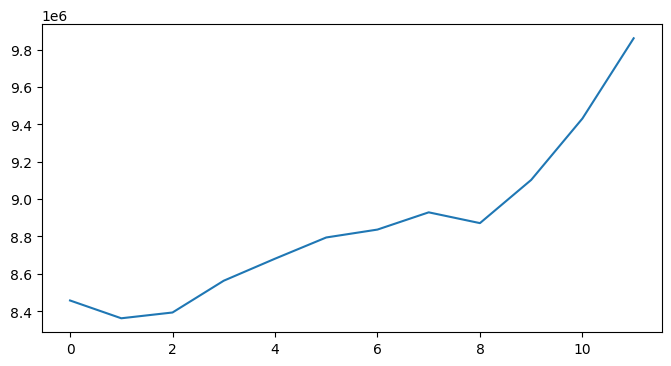

In [13]:
# total expenditure by month
total_exp = transactions.groupby(['YEAR','MONTH'],as_index=False)['AMOUNT'].sum()
plt.figure(figsize=(8, 4))
plt.plot(total_exp['AMOUNT'])

In [14]:
# Create a DataFrame with all unique combinations of 'CUST_ID' and 'EXP_TYPE'
CUST_ID = pd.DataFrame(transactions[['CUST_ID']].drop_duplicates()).reset_index(drop=True)
EXP_TYPE = pd.DataFrame(transactions[['EXP_TYPE']].drop_duplicates()).reset_index(drop=True)
cust_base = CUST_ID.assign(key=1).merge(EXP_TYPE.assign(key=1), on='key').drop('key',axis=1)

# Left join amounts
summed_data = transactions.groupby(['CUST_ID', 'EXP_TYPE'])['AMOUNT'].sum().reset_index()
result = cust_base.merge(summed_data, on=['CUST_ID', 'EXP_TYPE'], how='left').fillna(0)

# Make expenditure types the columns
result_pivoted = result.pivot(index='CUST_ID', columns='EXP_TYPE', values='AMOUNT').fillna(0)
result_pivoted.reset_index(inplace=True)
result_pivoted.head()

EXP_TYPE,CUST_ID,CLOTHING,EDUCATION,ENTERTAINMENT,FINES,GAMBLING,GROCERIES,HEALTH,HOUSING,TAX,TRAVEL,UTILITIES
0,C00A83JNR4,15040.0,0.0,28703.0,0.0,0.0,30914.0,14426.0,40228.0,12429.0,0.0,14935.0
1,C01OIZPW5S,3913.0,0.0,5621.0,0.0,0.0,39296.0,6853.0,45960.0,4631.0,21967.0,11152.0
2,C01UL9RQTT,6580.0,4151.0,12440.0,0.0,0.0,4278.0,2224.0,11892.0,1723.0,0.0,2061.0
3,C028BWZ221,8984.0,0.0,7424.0,0.0,0.0,57268.0,10503.0,0.0,6175.0,42908.0,14795.0
4,C05H7D1NS5,2444.0,0.0,19845.0,533.0,0.0,21178.0,3797.0,0.0,8639.0,0.0,10359.0


Text(0.5, 1.0, 'Correlation Matrix')

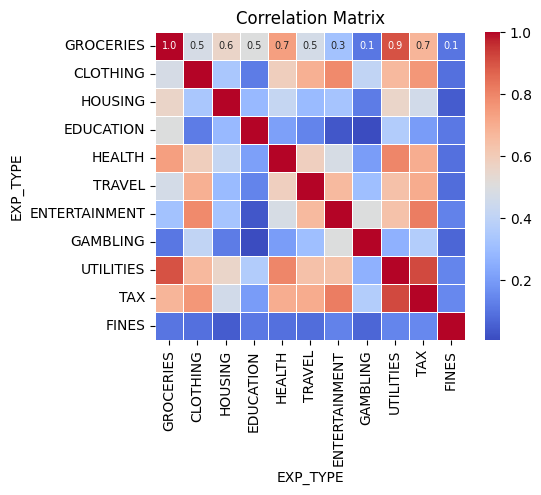

In [15]:
# Calculate the correlation matrix for the 'EXP_TYPEs'
correlation_matrix = result_pivoted[exp_types].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".1f", annot_kws={"size": 7})
plt.title('Correlation Matrix')

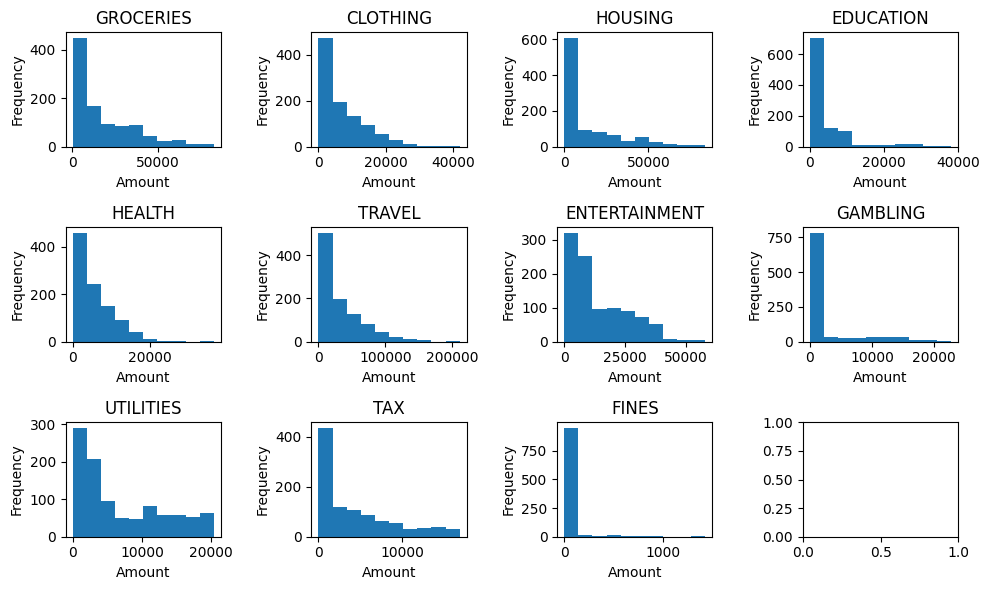

In [16]:

fig, axes = plt.subplots(3, 4, figsize=(10, 6))
axes = axes.ravel()  

# Plot a histogram for each 'EXP_TYPE'
for i, exp_type in enumerate(exp_types):
    ax = axes[i]
    result_pivoted[exp_type].plot(kind='hist', ax=ax)
    ax.set_title(f'{exp_type}')
    ax.set_xlabel('Amount')
    ax.set_ylabel('Frequency')
plt.tight_layout()


# Create feautures 

In [17]:
#Get a sample of transactions 
transactions = pd.read_csv('transactions.csv')
transactions.head()

,CUST_ID,CUST_TYPE,START_DATE,END_DATE,TRANS_ID,DATE,YEAR,MONTH,DAY,EXP_TYPE,AMOUNT
0,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TTXXZNQACF6MSMM,2022-08-23,2022,8,23,ENTERTAINMENT,18
1,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TNSJPJMEHQ7OZ8F,2022-11-03,2022,11,3,GROCERIES,25
2,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TSX7XM1U02I2DWT,2022-11-21,2022,11,21,HEALTH,12
3,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TJAM072A5SSDQNC,2022-03-11,2022,3,11,ENTERTAINMENT,11
4,CA2QHGY2Y9,Young Professional,2022-01-01,2022-12-31,TZ1YN73A217JTQR,2022-05-05,2022,5,5,GROCERIES,21


In [18]:
# Create a DataFrame with all unique combinations of 'CUST_ID', 'EXP_TYPE' and 'MONTH'
CUST_ID = pd.DataFrame(transactions[['CUST_ID']].drop_duplicates()).reset_index(drop=True)
EXP_TYPE = pd.DataFrame(transactions[['EXP_TYPE']].drop_duplicates()).reset_index(drop=True)
MONTH = pd.DataFrame(transactions[['MONTH']].drop_duplicates()).reset_index(drop=True)

base = CUST_ID.assign(key=1).merge(EXP_TYPE.assign(key=1), on='key').drop('key',axis=1)
base = base.assign(key=1).merge(MONTH.assign(key=1), on='key').drop('key',axis=1)
base.sort_values(['CUST_ID','MONTH'],inplace=True)
base.head()

,CUST_ID,EXP_TYPE,MONTH
34197,C00A83JNR4,ENTERTAINMENT,1
34209,C00A83JNR4,GROCERIES,1
34221,C00A83JNR4,HEALTH,1
34233,C00A83JNR4,UTILITIES,1
34245,C00A83JNR4,TAX,1


In [19]:
# Group by 'CUST_ID' and 'EXP_TYPE', and sum the 'AMOUNT' for each group
summed_data = transactions.groupby(['CUST_ID', 'EXP_TYPE','MONTH'])['AMOUNT'].sum().reset_index()
base = base.merge(summed_data, on=['CUST_ID', 'EXP_TYPE','MONTH'], how='left').fillna(0)

# calculate total expenditure for each month
base = base.pivot(index=['CUST_ID','MONTH'], columns='EXP_TYPE', values='AMOUNT').fillna(0)
base['EXPENDITURE'] = base[exp_types].sum(axis=1)
base.reset_index(inplace=True)
base.head()

EXP_TYPE,CUST_ID,MONTH,CLOTHING,EDUCATION,ENTERTAINMENT,FINES,GAMBLING,GROCERIES,HEALTH,HOUSING,TAX,TRAVEL,UTILITIES,EXPENDITURE
0,C00A83JNR4,1,2421.0,0.0,2340.0,0.0,0.0,2443.0,1798.0,3278.0,1033.0,0.0,1230.0,14543.0
1,C00A83JNR4,2,2447.0,0.0,2334.0,0.0,0.0,2467.0,1970.0,3291.0,1034.0,0.0,1240.0,14783.0
2,C00A83JNR4,3,0.0,0.0,2342.0,0.0,0.0,2495.0,1847.0,3305.0,1034.0,0.0,1233.0,12256.0
3,C00A83JNR4,4,0.0,0.0,2377.0,0.0,0.0,2495.0,1632.0,3318.0,1035.0,0.0,1246.0,12103.0
4,C00A83JNR4,5,2529.0,0.0,2417.0,0.0,0.0,2566.0,1593.0,3332.0,1035.0,0.0,1226.0,14698.0


In [20]:
# values for ratio of expenditure to income, savings and debt
per_exp = { 'income':{'Young Professional':[0.95,1.1],
                        'Experienced Professional':[1.1,1.5],
                        'Parent':[1,1.2],
                        'College Student':[0.80,1.1],
                        'School Student':[0.50,1.1],
                        'Retired':[0.9,1.1],
                        'Unemployed':[0,0]},
        'saving':{'Young Professional':[0.2,2],
                        'Experienced Professional':[1,5],
                        'Parent':[2,10],
                        'College Student':[0,1],
                        'School Student':[0,0.5],
                        'Retired':[5,15],
                        'Unemployed':[0.5,5]},
        'debt':{'Young Professional':[0,10],
                        'Experienced Professional':[2,15],
                        'Parent':[0,20],
                        'College Student':[0,30],
                        'School Student':[0,0],
                        'Retired':[0,2],
                        'Unemployed':[0,10]}
}

def get_ratio_to_exp(amount,finance_type,cust_type):

    """
    Get ratio of customer's finance_type to expenditure. 
    """

    #Get customer income range 
    min_ratio = per_exp[finance_type][cust_type][0]
    max_ratio = per_exp[finance_type][cust_type][1]
    
    #Create random income within customer range 
    ratio = np.random.uniform(min_ratio,max_ratio)
    ratio = round(ratio,1)# elimiate outliers
    new_amount = round(amount*ratio)
    return new_amount

,CUST_ID,CUST_TYPE,AMOUNT,INCOME,SAVING,DEBT
0,C00A83JNR4,Experienced Professional,156675,219345,720705,1331738
1,C01OIZPW5S,Parent,139393,139393,1129083,794540
2,C01UL9RQTT,Young Professional,45349,45349,27209,204070
3,C028BWZ221,Parent,148057,177668,888342,2398523
4,C05H7D1NS5,Experienced Professional,66795,80154,140270,387411


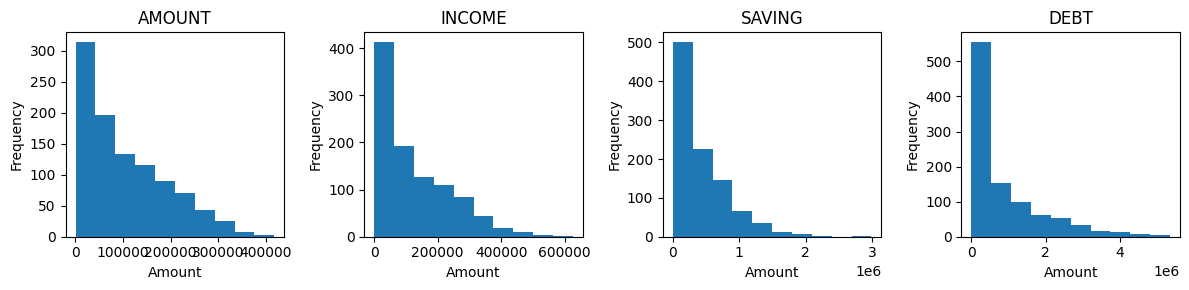

In [21]:
transactions_sum = transactions.groupby(['CUST_ID','CUST_TYPE'],as_index=False)['AMOUNT'].sum()

# percentage of total expenditure
transactions_sum['INCOME'] = transactions_sum.apply(lambda x: get_ratio_to_exp(x['AMOUNT'],'income',x['CUST_TYPE']),axis=1)
transactions_sum['SAVING'] = transactions_sum.apply(lambda x: get_ratio_to_exp(x['AMOUNT'],'saving',x['CUST_TYPE']),axis=1)
transactions_sum['DEBT'] = transactions_sum.apply(lambda x: get_ratio_to_exp(x['AMOUNT'],'debt',x['CUST_TYPE']),axis=1)

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes = axes.ravel()

# Plot a histograms
for i, exp_type in enumerate(['AMOUNT','INCOME','SAVING','DEBT']):
    ax = axes[i]
    transactions_sum[exp_type].plot(kind='hist', ax=ax)
    ax.set_title(f'{exp_type}')
    ax.set_xlabel('Amount')
    ax.set_ylabel('Frequency')
plt.tight_layout()


transactions_sum.head()

In [22]:
# Create transaction features
all_features = []

for CUST_ID,CUST_TYPE in transactions_sum[['CUST_ID','CUST_TYPE']].values:

    features = {'CUST_ID': CUST_ID,
                'CUST_TYPE': CUST_TYPE}

    cust_base = base[base['CUST_ID'] == CUST_ID]

    months_12 = cust_base.sum(axis=0)[2:]
    months_6 = cust_base[cust_base['MONTH'] > 6].sum(axis=0)[2:]

    features['INCOME'] = transactions_sum[transactions_sum['CUST_ID'] == CUST_ID]['INCOME'].values[0]
    features['SAVINGS'] = transactions_sum[transactions_sum['CUST_ID'] == CUST_ID]['SAVING'].values[0]
    features['DEBT'] = transactions_sum[transactions_sum['CUST_ID'] == CUST_ID]['DEBT'].values[0]

    # Financial position ratios
    if features['INCOME'] == 0:
        features['R_SAVINGS_INCOME'] = np.nan
        features['R_DEBT_INCOME'] = np.nan
    else:
        features['R_SAVINGS_INCOME'] = features['SAVINGS']/features['INCOME']
        features['R_DEBT_INCOME'] = features['DEBT']/features['INCOME']
    
    if features['SAVINGS'] == 0:
        features['R_DEBT_SAVINGS'] = np.nan
    else:
        features['R_DEBT_SAVINGS'] = features['DEBT']/features['SAVINGS']

    # Expenditure ratios
    for exp_type in cust_base.columns[2:]:
        features[f"T_{exp_type}_12"] = months_12[exp_type]
        features[f"T_{exp_type}_6"] = months_6[exp_type]

        if months_6[exp_type] == 0:
            features[f"R_{exp_type}"] = np.nan
        else:
            features[f"R_{exp_type}"] = months_6[exp_type]/months_12[exp_type]

        if features['INCOME'] == 0:
            features[f"R_{exp_type}_INCOME"] = np.nan
        else:
            features[f"R_{exp_type}_INCOME"] = months_12[exp_type]/features['INCOME']
        
        if features['SAVINGS'] == 0:
            features[f"R_{exp_type}_SAVINGS"] = np.nan
        else:
            features[f"R_{exp_type}_SAVINGS"] = months_12[exp_type]/features['SAVINGS']
        
        if features['DEBT'] == 0:
            features[f"R_{exp_type}_DEBT"] = np.nan
        else:
            features[f"R_{exp_type}_DEBT"] = months_12[exp_type]/features['DEBT']
    
    all_features.append(features)

df_features = pd.DataFrame(all_features)
print(df_features.columns)
df_features.head()

Index(['CUST_ID', 'CUST_TYPE', 'INCOME', 'SAVINGS', 'DEBT', 'R_SAVINGS_INCOME',
       'R_DEBT_INCOME', 'R_DEBT_SAVINGS', 'T_CLOTHING_12', 'T_CLOTHING_6',
       'R_CLOTHING', 'R_CLOTHING_INCOME', 'R_CLOTHING_SAVINGS',
       'R_CLOTHING_DEBT', 'T_EDUCATION_12', 'T_EDUCATION_6', 'R_EDUCATION',
       'R_EDUCATION_INCOME', 'R_EDUCATION_SAVINGS', 'R_EDUCATION_DEBT',
       'T_ENTERTAINMENT_12', 'T_ENTERTAINMENT_6', 'R_ENTERTAINMENT',
       'R_ENTERTAINMENT_INCOME', 'R_ENTERTAINMENT_SAVINGS',
       'R_ENTERTAINMENT_DEBT', 'T_FINES_12', 'T_FINES_6', 'R_FINES',
       'R_FINES_INCOME', 'R_FINES_SAVINGS', 'R_FINES_DEBT', 'T_GAMBLING_12',
       'T_GAMBLING_6', 'R_GAMBLING', 'R_GAMBLING_INCOME', 'R_GAMBLING_SAVINGS',
       'R_GAMBLING_DEBT', 'T_GROCERIES_12', 'T_GROCERIES_6', 'R_GROCERIES',
       'R_GROCERIES_INCOME', 'R_GROCERIES_SAVINGS', 'R_GROCERIES_DEBT',
       'T_HEALTH_12', 'T_HEALTH_6', 'R_HEALTH', 'R_HEALTH_INCOME',
       'R_HEALTH_SAVINGS', 'R_HEALTH_DEBT', 'T_HOUSING_12', 'T_

,CUST_ID,CUST_TYPE,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_12,T_CLOTHING_6,...,R_UTILITIES,R_UTILITIES_INCOME,R_UTILITIES_SAVINGS,R_UTILITIES_DEBT,T_EXPENDITURE_12,T_EXPENDITURE_6,R_EXPENDITURE,R_EXPENDITURE_INCOME,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT
0,C00A83JNR4,Experienced Professional,219345,720705,1331738,3.285714,6.071431,1.847827,15040.0,5208.0,...,0.502109,0.068089,0.020723,0.011215,156675.0,75387.0,0.481168,0.714286,0.217391,0.117647
1,C01OIZPW5S,Parent,139393,1129083,794540,8.099998,5.699999,0.703704,3913.0,1050.0,...,0.500986,0.080004,0.009877,0.014036,139393.0,56707.0,0.406814,1.000000,0.123457,0.175439
2,C01UL9RQTT,Young Professional,45349,27209,204070,0.599991,4.499989,7.500092,6580.0,3385.0,...,0.500243,0.045448,0.075747,0.010099,45349.0,23005.0,0.507288,1.000000,1.666691,0.222223
3,C028BWZ221,Parent,177668,888342,2398523,5.000011,13.500028,2.700000,8984.0,3958.0,...,0.500980,0.083273,0.016655,0.006168,148057.0,75753.0,0.511648,0.833335,0.166667,0.061728
4,C05H7D1NS5,Experienced Professional,80154,140270,387411,1.750006,4.833333,2.761895,2444.0,801.0,...,0.501303,0.129239,0.073850,0.026739,66795.0,34062.0,0.509948,0.833333,0.476189,0.172414


In [23]:
# Replace NaNs with random values
def clean_features(x,mean,std,col):
    if np.isnan(x) or np.isinf(x):
        x = np.random.normal(mean,std)
        x = max(0.0,x)
    
    if "R_" in col:
        return round(x,4)
    else:
        return round(x)

for col in df_features.columns[2:]:
    mean = df_features[col].mean()
    std = df_features[col].std()
    df_features[col] = df_features[col].apply(lambda x: clean_features(x,mean,std,col))

In [24]:
df_features.to_csv('features.csv',index=False)

df_features

,CUST_ID,CUST_TYPE,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_12,T_CLOTHING_6,...,R_UTILITIES,R_UTILITIES_INCOME,R_UTILITIES_SAVINGS,R_UTILITIES_DEBT,T_EXPENDITURE_12,T_EXPENDITURE_6,R_EXPENDITURE,R_EXPENDITURE_INCOME,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT
0,C00A83JNR4,Experienced Professional,219345,720705,1331738,3.2857,6.0714,1.8478,15040,5208,...,0.5021,0.0681,0.0207,0.0112,156675,75387,0.4812,0.7143,0.2174,0.1176
1,C01OIZPW5S,Parent,139393,1129083,794540,8.1000,5.7000,0.7037,3913,1050,...,0.5010,0.0800,0.0099,0.0140,139393,56707,0.4068,1.0000,0.1235,0.1754
2,C01UL9RQTT,Young Professional,45349,27209,204070,0.6000,4.5000,7.5001,6580,3385,...,0.5002,0.0454,0.0757,0.0101,45349,23005,0.5073,1.0000,1.6667,0.2222
3,C028BWZ221,Parent,177668,888342,2398523,5.0000,13.5000,2.7000,8984,3958,...,0.5010,0.0833,0.0167,0.0062,148057,75753,0.5116,0.8333,0.1667,0.0617
4,C05H7D1NS5,Experienced Professional,80154,140270,387411,1.7500,4.8333,2.7619,2444,801,...,0.5013,0.1292,0.0739,0.0267,66795,34062,0.5099,0.8333,0.4762,0.1724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,CZSM7B77VP,Young Professional,117384,211291,363890,1.8000,3.1000,1.7222,14007,9564,...,0.5031,0.0377,0.0209,0.0122,117384,69139,0.5890,1.0000,0.5556,0.3226
996,CZUIEOYW94,Young Professional,99930,129909,439692,1.3000,4.4000,3.3846,11730,5434,...,0.5053,0.0322,0.0247,0.0073,99930,44671,0.4470,1.0000,0.7692,0.2273
997,CZXKA7TFHL,Experienced Professional,56895,108618,584470,1.9091,10.2728,5.3810,3722,2517,...,0.5030,0.1239,0.0649,0.0121,51723,27060,0.5232,0.9091,0.4762,0.0885
998,CZYWO5OT0T,Parent,75704,264965,656105,3.5000,8.6667,2.4762,3081,2248,...,0.5008,0.0681,0.0195,0.0079,63087,33140,0.5253,0.8333,0.2381,0.0962


# Generate credit scores

No      606
High    266
Low     128
Name: GAMBLING_CAT, dtype: int64
       R_EXPENDITURE         INCOME  R_DEBT_INCOME  R_ENTERTAINMENT
count    1000.000000    1000.000000    1000.000000      1000.000000
mean        0.511508  124758.491000       6.035362         0.532434
std         0.072464  113721.902303       5.869617         0.050485
min         0.247500       0.000000       0.000000         0.376400
25%         0.481625   32531.000000       1.400000         0.506700
50%         0.518100   89180.000000       4.700000         0.510400
75%         0.550075  194622.750000       8.900000         0.516825
max         0.756300  626176.000000      36.875000         0.678000


,R_EXPENDITURE,INCOME,R_DEBT_INCOME,R_ENTERTAINMENT,GAMBLING_CAT
0,0.4812,219345,6.0714,0.5089,No
1,0.4068,139393,5.7000,0.5067,No
2,0.5073,45349,4.5000,0.5152,No
3,0.5116,177668,13.5000,0.5187,No
4,0.5099,80154,4.8333,0.5136,No


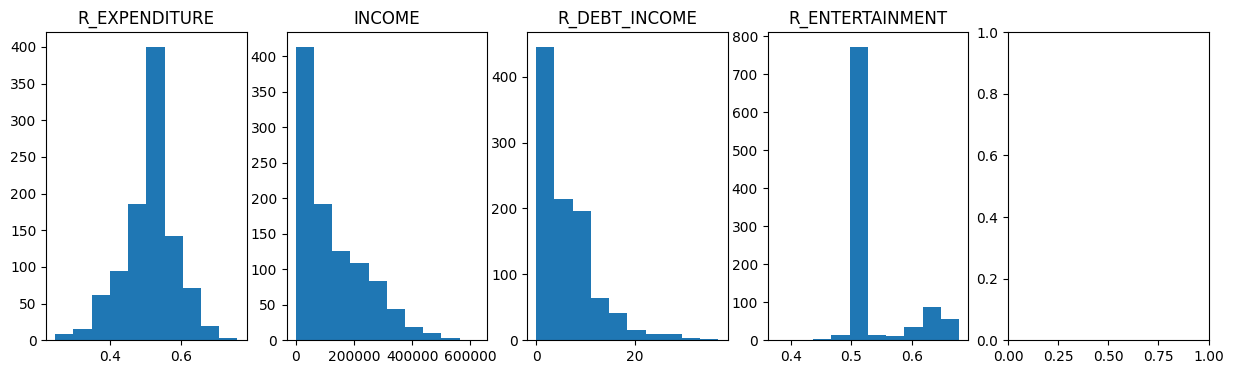

In [25]:
# Select features used to generate credit score
df_selected = df_features[['R_EXPENDITURE','INCOME','R_DEBT_INCOME','R_ENTERTAINMENT','T_GAMBLING_12']].copy()

# Categorical feature for gambling
df_selected['GAMBLING_CAT'] = pd.cut(df_selected['T_GAMBLING_12'],bins=[-1,1,1000,50000],labels=['No','Low','High'])
print(df_selected['GAMBLING_CAT'].value_counts())
df_selected.drop('T_GAMBLING_12',axis=1,inplace=True)

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i,col in enumerate(df_selected.columns[:-1]):

    axes[i].hist(df_selected[col])
    axes[i].set_title(col)

# summary
print(df_selected.describe())
df_selected.head()

In [26]:
# Get model features
X = df_selected[['R_EXPENDITURE','INCOME','R_DEBT_INCOME','R_ENTERTAINMENT']].copy()
X['R_EXPENDITURE_SQR'] = X['R_EXPENDITURE']**2
X['GAMBLING_NONE'] = df_selected['GAMBLING_CAT'].apply(lambda x: 1 if x == 'No' else 0)
X['GAMBLING_LOW'] = df_selected['GAMBLING_CAT'].apply(lambda x: 1 if x == 'Low' else 0)
X['GAMBLING_HIGH']  = df_selected['GAMBLING_CAT'].apply(lambda x: 1 if x == 'High' else 0)

X = X[['R_EXPENDITURE','R_EXPENDITURE_SQR','INCOME','R_DEBT_INCOME','R_ENTERTAINMENT','GAMBLING_LOW','GAMBLING_HIGH']]
X.head()

,R_EXPENDITURE,R_EXPENDITURE_SQR,INCOME,R_DEBT_INCOME,R_ENTERTAINMENT,GAMBLING_LOW,GAMBLING_HIGH
0,0.4812,0.231553,219345,6.0714,0.5089,0,0
1,0.4068,0.165486,139393,5.7000,0.5067,0,0
2,0.5073,0.257353,45349,4.5000,0.5152,0,0
3,0.5116,0.261735,177668,13.5000,0.5187,0,0
4,0.5099,0.259998,80154,4.8333,0.5136,0,0


In [27]:
# Scale features
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#X_2 = scaler_2.fit_transform(X_1)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)

X_scaled['GAMBLING_LOW'] = X['GAMBLING_LOW']
X_scaled['GAMBLING_HIGH'] = X['GAMBLING_HIGH']

X_scaled.head()

,R_EXPENDITURE,R_EXPENDITURE_SQR,INCOME,R_DEBT_INCOME,R_ENTERTAINMENT,GAMBLING_LOW,GAMBLING_HIGH
0,-0.418464,-0.487581,0.832151,0.006143,-0.466400,0,0
1,-1.445696,-1.399277,0.128751,-0.057164,-0.509999,0,0
2,-0.058105,-0.131555,-0.698627,-0.261709,-0.341547,0,0
3,0.001265,-0.071096,0.465486,1.272378,-0.272185,0,0
4,-0.022207,-0.095059,-0.392421,-0.204896,-0.373256,0,0


In [28]:
# did not use this function in the end

def base_score(CUST_TYPE):
    d=100
    if CUST_TYPE == 'Young Professional':
        score = 0.01/d
    elif CUST_TYPE == 'Experienced Professional':
        score = 0.05/d
    elif CUST_TYPE == 'Parent':
        score = 0.05/d
    elif CUST_TYPE == 'College Student':
        score = -0.01/d
    elif CUST_TYPE == 'School Student':
        score = -0.05/d
    elif CUST_TYPE == 'Retired':
        score = -0.05/d
    elif CUST_TYPE == 'Unemployed':
        score = -0.1/d
    return score


                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     873.7
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:12:37   Log-Likelihood:                -4665.3
No. Observations:                1000   AIC:                             9347.
Df Residuals:                     992   BIC:                             9386.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               827.9072     25.86

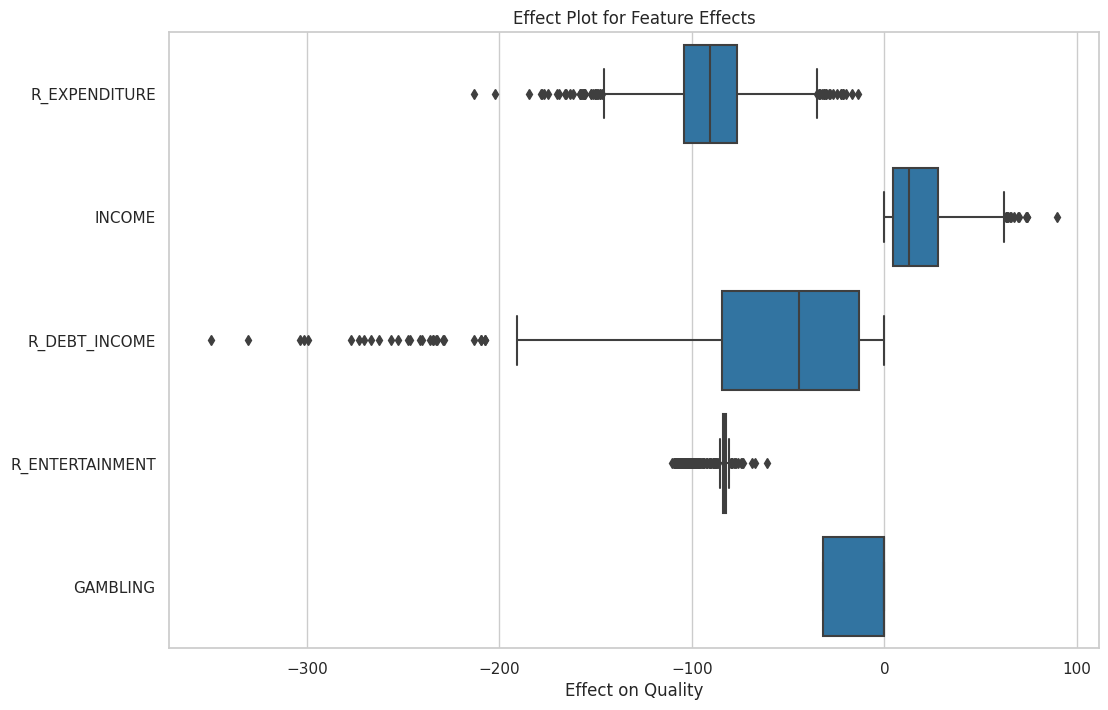

In [29]:
import statsmodels.api as sm

# Generate credit score
params = {'1':0.01,'2':-0.03,'3':0.01,'4':-0.04,'5':-0.005,'6':-0.02,'7':-0.005,'8':-0.02}
var = {'1':0.00,'2':0.00,'3':0.03,'4':0.01,'5':0.001,'6':0.001,'7':0.001,'8':0.01}
X_scaled['BASE_SCORE'] = df_features['CUST_TYPE'].apply(lambda x: base_score(x))

CREDIT_SCORE = []
for i in range(len(X_scaled)):
    CREDIT_SCORE.append((1+ X_scaled['BASE_SCORE'][i] + 
    (params['1'] + np.random.uniform(-var['1'],var['1'])) * X_scaled['R_EXPENDITURE'][i] +
    (params['2'] + np.random.uniform(-var['2'],var['2'])) * X_scaled['R_EXPENDITURE_SQR'][i] +
    (params['3'] + np.random.uniform(-var['3'],var['3'])) * X_scaled['INCOME'][i] +
    (params['4'] + np.random.uniform(-var['4'],var['4'])) * X_scaled['R_DEBT_INCOME'][i] +
    (params['5'] + np.random.uniform(-var['5'],var['5'])) * X_scaled['R_ENTERTAINMENT'][i] +
   # (params['6'] + np.random.uniform(-var['6'],var['6'])) * X_scaled['R_EXPENDITURE_SAVINGS'][i] +
    (params['7'] + np.random.uniform(-var['7'],var['7'])) * X_scaled['GAMBLING_LOW'][i] +
    (params['8'] + np.random.uniform(-var['8'],var['8'])) * X_scaled['GAMBLING_HIGH'][i]
    ))

#X_scaled['CREDIT_SCORE'] =[min] np.min(1.6,CREDIT_SCORE)
X_scaled['CREDIT_SCORE'] = np.exp(CREDIT_SCORE)

# model features
#X['R_EXPENDITURE_SQR'] = X['R_EXPENDITURE']**2
#X = X[['R_EXPENDITURE','R_EXPENDITURE_SQR','INCOME','R_DEBT_INCOME','R_ENTERTAINMENT','R_EXPENDITURE_SAVINGS','GAMBLING_LOW','GAMBLING_HIGH']]

y = (X_scaled['CREDIT_SCORE'] - np.min(X_scaled['CREDIT_SCORE']))/(np.max(X_scaled['CREDIT_SCORE']) - np.min(X_scaled['CREDIT_SCORE']))
y = y.apply(lambda x: round(x*500+300))

# Add a constant to the independent variables (intercept)
X = sm.add_constant(X)

# Fit a linear regression model
model = sm.OLS(y, X).fit()

# Output the summary of the model
model_summary = model.summary()

# Print the summary
print(model_summary)

# Calculate the feature effects by multiplying weights with feature values
feature_effects = X * model.params

feature_effects['R_EXPENDITURE'] = feature_effects['R_EXPENDITURE'] + feature_effects['R_EXPENDITURE_SQR']
feature_effects['GAMBLING'] = feature_effects['GAMBLING_LOW']+feature_effects['GAMBLING_HIGH']
feature_effects.drop(['const','R_EXPENDITURE_SQR','GAMBLING_LOW','GAMBLING_HIGH'],axis=1,inplace=True)

# Create effect plots using boxplots
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
#box plot with no tails
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue")
plt.title("Effect Plot for Feature Effects")
#plt.xlim(-200,100)
plt.xlabel("Effect on Quality")
plt.show()


Text(0, 0.5, 'Actual')

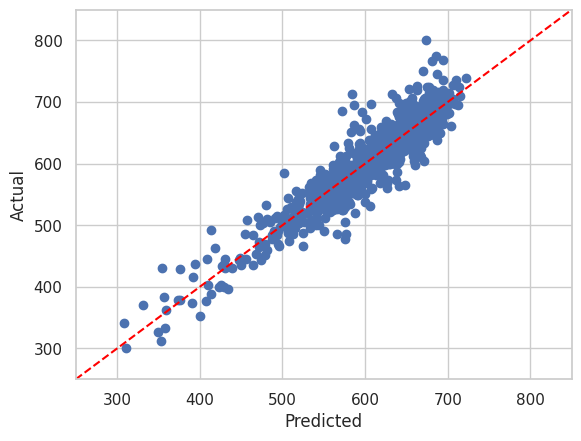

In [30]:
#plot predicted vs actual and straight line
y_pred = model.predict(X)
plt.scatter(y_pred,y)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red', linestyle='--')
plt.ylim(250,850)
plt.xlim(250,850)
plt.xlabel('Predicted')
plt.ylabel('Actual')

,R_EXPENDITURE,R_EXPENDITURE_SQR,INCOME,R_DEBT_INCOME,R_ENTERTAINMENT,GAMBLING_LOW,GAMBLING_HIGH,BASE_SCORE,CREDIT_SCORE
0,-0.418464,-0.487581,0.832151,0.006143,-0.466400,0,0,0.0005,2.794532
1,-1.445696,-1.399277,0.128751,-0.057164,-0.509999,0,0,0.0005,2.818876
2,-0.058105,-0.131555,-0.698627,-0.261709,-0.341547,0,0,0.0001,2.727725
3,0.001265,-0.071096,0.465486,1.272378,-0.272185,0,0,0.0005,2.557461
4,-0.022207,-0.095059,-0.392421,-0.204896,-0.373256,0,0,0.0005,2.755722


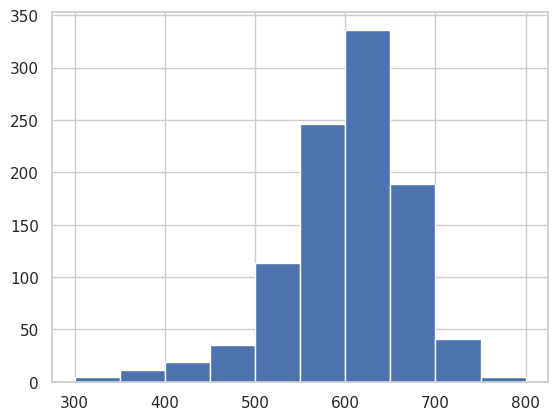

In [31]:
y.hist()
X_scaled.head()

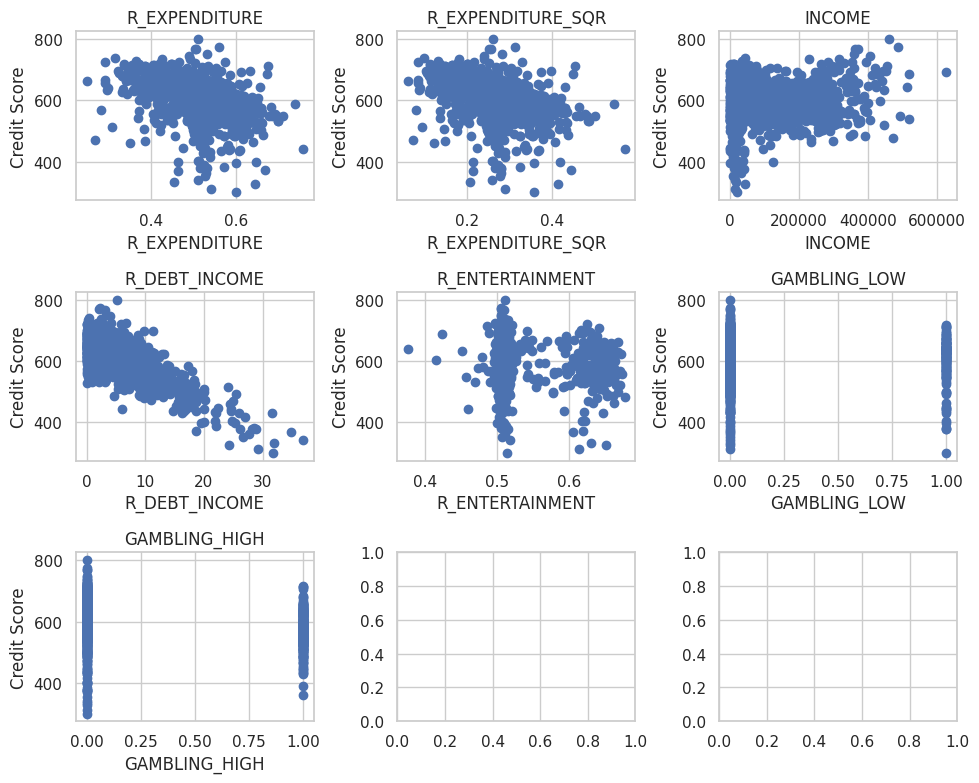

In [32]:
# scatter plot of X and y
fig, axes = plt.subplots(3, 3, figsize=(10, 8))
axes = axes.ravel()  # Flatten the 2D array of axes

for i,col in enumerate(X.columns[1:]):
    axes[i].scatter(X[col], y)
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Credit Score')

plt.tight_layout()

/mnt/e/Github/XAI-tutorial/.venv/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


Text(0.5, 1.0, 'Correlation Matrix')

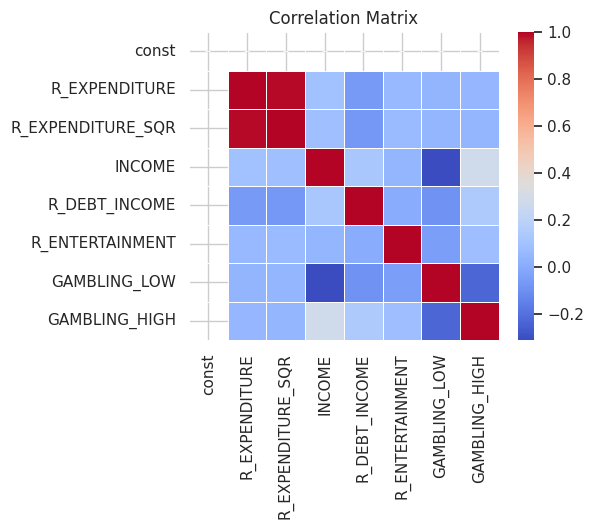

In [33]:
# Calculate the correlation matrix for the 'EXP_TYPEs'
correlation_matrix = X.corr()

# Create a Seaborn heatmap for the correlation matrix
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".1f", annot_kws={"size": 7})
plt.title('Correlation Matrix')

In [34]:
# Save final dataset
transaction_features = df_features.drop(['CUST_TYPE'],axis=1).copy()
transaction_features['GAMBLING_CAT'] = df_selected['GAMBLING_CAT']
transaction_features['CREDIT_SCORE'] = y

transaction_features.to_csv('transaction_features.csv',index=False)
transaction_features.head()

,CUST_ID,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_12,T_CLOTHING_6,R_CLOTHING,...,R_UTILITIES_SAVINGS,R_UTILITIES_DEBT,T_EXPENDITURE_12,T_EXPENDITURE_6,R_EXPENDITURE,R_EXPENDITURE_INCOME,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT,GAMBLING_CAT,CREDIT_SCORE
0,C00A83JNR4,219345,720705,1331738,3.2857,6.0714,1.8478,15040,5208,0.3463,...,0.0207,0.0112,156675,75387,0.4812,0.7143,0.2174,0.1176,No,649
1,C01OIZPW5S,139393,1129083,794540,8.1000,5.7000,0.7037,3913,1050,0.2683,...,0.0099,0.0140,139393,56707,0.4068,1.0000,0.1235,0.1754,No,662
2,C01UL9RQTT,45349,27209,204070,0.6000,4.5000,7.5001,6580,3385,0.5144,...,0.0757,0.0101,45349,23005,0.5073,1.0000,1.6667,0.2222,No,614
3,C028BWZ221,177668,888342,2398523,5.0000,13.5000,2.7000,8984,3958,0.4406,...,0.0167,0.0062,148057,75753,0.5116,0.8333,0.1667,0.0617,No,525
4,C05H7D1NS5,80154,140270,387411,1.7500,4.8333,2.7619,2444,801,0.3277,...,0.0739,0.0267,66795,34062,0.5099,0.8333,0.4762,0.1724,No,629


In [35]:
# Add some categorical features 

transaction_features = pd.read_csv('transaction_features.csv')
CREDIT_SCORE = transaction_features['CREDIT_SCORE']
transaction_features.drop('CREDIT_SCORE',axis=1,inplace=True)

# All categorical features should have CAT in front of them
column_names = transaction_features.columns.values
column_names[-1] = 'CAT_GAMBLING'

transaction_features.comlumns = column_names

#DEBT
DEBT = transaction_features['DEBT']
DEBT = (DEBT - np.min(DEBT))/(np.max(DEBT) - np.min(DEBT))
transaction_features['CAT_DEBT'] = [1 if d> 0 else 0 for d in DEBT]

#CREDIT CARD
CAT_CREDIT_CARD = [1 if random.uniform(0,0.5) < d else 0 for d in DEBT]
transaction_features['CAT_CREDIT_CARD'] = CAT_CREDIT_CARD

#OVERDRAFT
CAT_CREDIT_CARD = [1 if random.uniform(0,0.5) < d else 0 for d in DEBT]
transaction_features['CAT_CREDIT_CARD'] = CAT_CREDIT_CARD

#MORTGAGE
HOUSING = transaction_features['T_HOUSING_12']
HOUSING = (HOUSING- np.min(HOUSING))/(np.max(HOUSING) - np.min(HOUSING))
CAT_MORTGAGE= [1 if random.uniform(0,0.7) < d else 0 for d in HOUSING]
transaction_features['CAT_MORTGAGE'] = CAT_MORTGAGE

#SAVINGS ACCOUNT
transaction_features['CAT_SAVINGS_ACCOUNT'] = [1 if d> 0 else 0 for d in transaction_features['SAVINGS']]

# DEBENDENTS
transactions = pd.read_csv('transactions.csv')
CUST_ID = pd.DataFrame(transactions[['CUST_ID','CUST_TYPE']].drop_duplicates()).reset_index(drop=True)
CUST_TYPE = {}
for i,row in CUST_ID.iterrows():
    if row['CUST_TYPE'] == 'Parent':
        CUST_TYPE[row['CUST_ID']] = 1
    else:
        CUST_TYPE[row['CUST_ID']] = 0
transaction_features['CAT_DEPENDENTS'] = transaction_features['CUST_ID'].apply(lambda x: CUST_TYPE[x])


print(transaction_features['CAT_DEBT'].value_counts())
print(transaction_features['CAT_CREDIT_CARD'].value_counts())
print(transaction_features['CAT_MORTGAGE'].value_counts())
print(transaction_features['CAT_DEPENDENTS'].value_counts())
print(transaction_features['CAT_SAVINGS_ACCOUNT'].value_counts())
transaction_features.head()

/tmp/ipykernel_1777872/2149229380.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transaction_features.comlumns = column_names


1    942
0     58
Name: CAT_DEBT, dtype: int64
0    713
1    287
Name: CAT_CREDIT_CARD, dtype: int64
0    792
1    208
Name: CAT_MORTGAGE, dtype: int64
0    850
1    150
Name: CAT_DEPENDENTS, dtype: int64
1    992
0      8
Name: CAT_SAVINGS_ACCOUNT, dtype: int64


,CUST_ID,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_12,T_CLOTHING_6,R_CLOTHING,...,R_EXPENDITURE,R_EXPENDITURE_INCOME,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT,CAT_GAMBLING,CAT_DEBT,CAT_CREDIT_CARD,CAT_MORTGAGE,CAT_SAVINGS_ACCOUNT,CAT_DEPENDENTS
0,C00A83JNR4,219345,720705,1331738,3.2857,6.0714,1.8478,15040,5208,0.3463,...,0.4812,0.7143,0.2174,0.1176,No,1,1,1,1,0
1,C01OIZPW5S,139393,1129083,794540,8.1000,5.7000,0.7037,3913,1050,0.2683,...,0.4068,1.0000,0.1235,0.1754,No,1,0,1,1,1
2,C01UL9RQTT,45349,27209,204070,0.6000,4.5000,7.5001,6580,3385,0.5144,...,0.5073,1.0000,1.6667,0.2222,No,1,0,1,1,0
3,C028BWZ221,177668,888342,2398523,5.0000,13.5000,2.7000,8984,3958,0.4406,...,0.5116,0.8333,0.1667,0.0617,No,1,1,0,1,1
4,C05H7D1NS5,80154,140270,387411,1.7500,4.8333,2.7619,2444,801,0.3277,...,0.5099,0.8333,0.4762,0.1724,No,1,0,0,1,0


0    731
1    269
Name: DEFAULT, dtype: int64


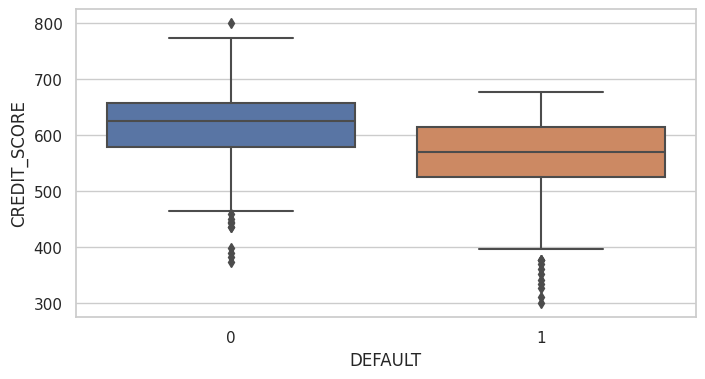

In [36]:
# Add target variables
transaction_features['CREDIT_SCORE'] = CREDIT_SCORE

DEFAULT = []
for score in transaction_features['CREDIT_SCORE']:
    score = (score-300)/500
    if score < random.uniform(0,0.8):
        DEFAULT.append(1)
    else:
        DEFAULT.append(0)

transaction_features['DEFAULT'] = DEFAULT

# box plot of credit score by default
plt.figure(figsize=(8, 4))
sns.boxplot(x="DEFAULT", y="CREDIT_SCORE", data=transaction_features)

print(transaction_features['DEFAULT'].value_counts())

In [37]:
# save final dataset
#transaction_features.to_csv('../../data/credit_score.csv',index=False)